# Recurrent Neural Networks
page 381<br>
For details, see
- https://github.com/ageron/handson-ml/blob/master/14_recurrent_neural_networks.ipynb,
- https://magenta.tensorflow.org (TensorFlow Magenta for music generation),
- https://danijar.com/introduction-to-recurrent-networks-in-tensorflow/ (tutorial),
- https://www.programcreek.com/python/example/102773/tensorflow.contrib.rnn.MultiRNNCell (exmple implementations),
- https://www.tensorflow.org/tutorials/representation/word2vec (TensorFlow Word2Vec tutorial, see also downloaded PDF version "VectorRepresentationsOfWordsTensorFlow.pdf"),
- https://github.com/tensorflow/nmt/tree/tf-1.4 (TensorFlow Seq2Seq tutorial), and
- http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/ (another useful tutorial).

Anticipating what happens next, based on past events and previous experience is something humans do almost all the time, e.g., when catching a ball. This chapter is dedicated to **recurrent neural networks** (RNNs), a class of networks that aims at predicting the future based on training and past events. They analyze time series and are used for stock price prediction as well as for autonomous driving. More generally, they process **sequences** of arbitrary length. For example, they take sentences, documents, or audio samples as input. This makes them useful for natural language processing (NLP) where they are used, for example, for sentiment analysis, automatic translation, or speech-to-text conversion.

RNN's ability to anticipate what comes next makes them useful for creative tasks. For example, an audio sequence (*music*) can be composed by predicting the next tone one at a time, see Google's **Magenta project** (http://goo.gl/IxIL1V and https://magenta.tensorflow.org) for details. But RNNs can also generate sentences (http://goo.gl/onkPNd), image captions (http://goo.gl/Nwx7Kh), and much more.

This chapter is about the fundamental concepts of RNNs and their problems (vanishing/exploding gradients, see Chapter 11) as well as the ideas used for solving these problems: LSTM and GRU cells.
## Recurrent Neurons
page 382<br>
Apart from several networks in Appendix E (e.g., deep belief networks), we have mostly studied feedforward (information flows in only one direction) networks up to now. Recurrent neural networks work and look very much like a feedforward network but for the fact that at any time step, a **recurrent neuron** produces an output and combines it with the default features to the total input for the next time step. Depicting - as a function of time - the output $y_{(t-1)}$ of the network and how it is added to the input $x_{(t)}$ for the next time step, is called **unrolling the network through time** (see also Figure 14-1 on page 382 in the book). The inputs (and the outputs) at all the time steps can be written as a vector (or as a higher tensor).<br>
Each recurrent neurons has weights $w_x$ for the current input instances and weights $w_y$ for acceptance of the previous output $y_{(t-1)}$. With $\phi(\cdot)$ as the activation function, one may thus write the output of the recurrent neuron for a single instance as (Equation 14-1 in the book)

$$y_{(t)}=\phi\left(x_{(t)}^T\cdot w_x+y_{(t-1)}^T\cdot w_y+b\right)\,.$$
<br>A whole RNN layer's output for an entire batch can be computed with (Equation 14-2 in the book)

$$Y_{(t)}=\phi\left(X_{(t)}\cdot W_x+Y_{(t-1)}\cdot W_y+b\right)=\phi\left(\begin{pmatrix}X_{(t)}\\Y_{(t-1)}\end{pmatrix}\cdot\begin{pmatrix}W_x\\W_y\end{pmatrix}+b\right)\,,$$
where
- $Y_{(t)}$ is an $m\times n_{\rm neurons}$ matrix containing the layer's outputs at time step $t$ for each instance in the mini-batch ($m$ is the number of instances in the mini-batch and $n_{\rm neurons}$ is the number of neurons),
- $X_{(t)}$ is an $m\times n_{\rm inputs}$ matrix containing the inputs for all instances ($n_{\rm inputs}$ is the number of input features),
- $W_x$ is an $n_{\rm inputs}\times n_{\rm neurons}$ matrix containing the connection weights for the inputs of the current time step,
- $W_y$ is an $n_{\rm neurons}\times n_{\rm neurons}$ matrix containing the connection weights for the outputs of the previous time step,
- the weight matrices $W_x$ and $W_y$ are often concatenated into a single weight matrix $W$ of shape $\left((n_{\rm inputs}+n_{\rm neurons})\times n_{\rm neurons}\right)$ (see the Equaton 14-2 above), and
- $b$ is a vector of size $n_{\rm neurons}$ containing each neuron's bias term.

Note that $Y_{(t)}$ is a function of $X_{(t)}$ and Y_{(t-1)}, which is a function of $X_{(t-1)}$ and Y_{(t-2)}, and so on. This way, $Y_{(t)}$ depends on all the previous inputs. For the initial input, there is no previous output $Y$ so it is usually set substituted by zeros.

**Note**: Some researchers prefer the **tanh** over the **ReLU** activation function for RNNs, see https://goo.gl/2WSnaj (but at the same time, https://goo.gl/NrKAP0 might also be relevant).
## Memory Cells
page 384<br>
RNNs have some kind of **memory** in that their ouptuts depend on all previous inputs. A **memory cell** (or simply **cell**) is a part of an RNN that preserves a certain state over several time steps. A single recurrent neuron or layer of neurons is a very basic cell. We will learn about more advanced cells (LSTM, GRU) later in this chapter.

Consequently, a cells *hidden* state $h_{(t)}$ is a function of the current input and its previous state: $h_{(t)}=f(h_{(t-1)},x_{(t)})$. And the same is true for its output $y_{(t)}$. For the very basic cell we are assuming so far, the output is simply the cell's state, $y_{(t)}=h_{(t)}$. This is not necessarily true for more elaborate cells: the state $h_{(t)}$ **is fed forward** but the output $y_{(t)}$ might only be relevant as the **final output** at the end of the sequence.
## Input and Output Sequences
page 384<br>
RNNs can simultaneously receive an input sequences and produce an output sequence. So one may train an RNN on an input time series (sequence in discrete days) such that it returns the same time series but shifted one time step (day) into the future. This is a supervised training task and it can be used to *make predictions of stock prices*, for example. One could also just ignore all outputs but the final one, if a **sequence-to-vector** map is required instead of a **sequence-to-sequence** map (in general, each time step may be characterised by a vector, both for input and output). A possible application is *movie ranking* (say, $-1$ for worst movie and $+1$ for best movie) based on several reviews (each review is an instance of a sequence).

For a **vector-to-sequence** map one would just feed one initial input and then consequtively produce an output and feed the cell's internal state forward as the sole input for the next time step. This can be used for *image captioning*. Finally, one may employ a **sequence-to-vector** network (the **encoder**) followed by a **vector-to-sequence** network (the **decoder**). The encoder feeds its output vector as the input to the decoder. This can be used for translating a sentence (sequence of words) to another language (another sequence of words). It makes sense to first process the input sequence entirely and start translation to another sequence afterwards because the last word in the input (original) sentence can impact the first word of the output (translated) sentence. Now, let's start coding!

## Basic RNNs in TensorFlow
page 386<br>
For better understanding, we will first try out a simple RNN with TensorFlow but without relying on TenorFlow's predefined RNN implementations. We use a single layer with five recurrent neurons that use the tanh activation function, and receive input vectors of size 3 at each of 2 time steps. A sketch of the **unrolled network** is shown below (related to Figure 14-2 on page 382 of the book).

<img src="images/BasicRNN.png">

In [1]:
# imports
import numpy as np
import tensorflow as tf
import os
import matplotlib
import matplotlib.pyplot as plt
# useful stuff
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
# basic rnn
reset_graph() # always a good idea
n_inputs = 3  # each instance has 3 features per time step (there are 4 instances, see mini-batch below)
n_neurons = 5 # the cell consists of a single layer with 5 neurons
X0 = tf.placeholder(tf.float32, [None, n_inputs])                                  # input of first time step
X1 = tf.placeholder(tf.float32, [None, n_inputs])                                  # input of second time step
Wx = tf.Variable(tf.random_normal(shape=[n_inputs , n_neurons], dtype=tf.float32)) # random weights of first and ...
Wy = tf.Variable(tf.random_normal(shape=[n_neurons, n_neurons], dtype=tf.float32)) # ... time step (no training, here)
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))                        # bias term (0, no training, here)
Y0 = tf.tanh(tf.matmul(X0, Wx) + b)                                                # output of first time step
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)                            # output of second time step
init = tf.global_variables_initializer()                                           # initialize random weights Wx, Wy
# mini-batch:        instance 0, instance 1, instance 2, instance 3
X0_batch = np.array([[0, 1, 2],  [3, 4, 5],  [6, 7, 8],  [9, 0, 1]])               # t = 0
X1_batch = np.array([[9, 8, 7],  [0, 0, 0],  [6, 5, 4],  [3, 2, 1]])               # t = 1
with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})    # calculate outputs
print(Y0_val) # output at t = 0
print(Y1_val) # output at t = 1

/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:496: FutureWarning: Passing (type, 1) or 

[[-0.0664006   0.9625767   0.68105793  0.7091854  -0.898216  ]
 [ 0.9977755  -0.719789   -0.9965761   0.9673924  -0.9998972 ]
 [ 0.99999774 -0.99898803 -0.9999989   0.9967762  -0.9999999 ]
 [ 1.         -1.         -1.         -0.99818915  0.9995087 ]]
[[ 1.         -1.         -1.          0.4020025  -0.9999998 ]
 [-0.12210421  0.6280527   0.9671843  -0.9937122  -0.25839362]
 [ 0.9999983  -0.9999994  -0.9999975  -0.8594331  -0.9999881 ]
 [ 0.99928284 -0.99999815 -0.9999058   0.9857963  -0.92205757]]


Note that the bias $b$ and the weights $Wx$ are used in the same fashion for every time step. No training is taking place in this very simplistic model. Before doing more complicated things, we shall redo the same network with TensorFlow.
### Static Unrolling Through Time
page 387<br>
As a start, we recreate the above network via TensorFlow's `BasicRNNCell()`, which is not an RNN cell itself but rather a factory of RNN cells – with specified architecture – that produces the desired RNN cells on demand. This is useful because the longer the input sequence, the more unrolled RNN cells will be required. And that can be quite many.

In [2]:
# basic idea of an unrolled RNN
reset_graph()                                     # always a good idea
X0 = tf.placeholder(tf.float32, [None, n_inputs]) # input placeholder for first time step
X1 = tf.placeholder(tf.float32, [None, n_inputs]) # input placeholder for second time step
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)                           # basic RNN cell factory
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1], dtype=tf.float32) # apply the cell factory ...
# ... for every time step, chain the cells together, feed the input placeholders, and obtain the output sequences ...
# ... (one sequence for each instance of the batch) as well as the sequences of the chained cells' states
Y0, Y1 = output_seqs # collect the outputs
print(Y0)            # output of first cell (2 instances)
print(Y1)            # output of second cell (2 instances)
# github: initialize variables, feed batches during session to calculate output, and print the output
init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})
print(Y0_val)
print(Y1_val)

Tensor("rnn/basic_rnn_cell/Tanh:0", shape=(?, 5), dtype=float32)
Tensor("rnn/basic_rnn_cell/Tanh_1:0", shape=(?, 5), dtype=float32)
[[ 0.30741334 -0.32884315 -0.6542847  -0.9385059   0.52089024]
 [ 0.99122757 -0.9542542  -0.7518079  -0.9995208   0.9820235 ]
 [ 0.9999268  -0.99783254 -0.8247353  -0.9999963   0.99947774]
 [ 0.996771   -0.68750614  0.8419969   0.9303911   0.8120684 ]]
[[ 0.99998885 -0.9997605  -0.06679298 -0.9999804   0.99982214]
 [-0.6524944  -0.51520866 -0.37968954 -0.59225935 -0.08968385]
 [ 0.998624   -0.997152   -0.03308626 -0.9991565   0.9932902 ]
 [ 0.99681675 -0.9598194   0.39660636 -0.8307605   0.7967197 ]]


Using the cell factory `BasicRNNCell()`, we do not need to manually build the RNN cell for each individual step in the sequence. But we still need to build the input placeholders and collect the output as well as the state for each step. These shall be automated, too! Otherwise, we will have a difficult time with scaling up RNNs! So lets (un-) pack the relevant quantities for different sequence steps via TensorFlow's `tf.stack()` and `tf.unstack()` commands!

In [3]:
reset_graph()
n_steps = 2
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])     # single input placeholder
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]))          # unstack X such that the result is a sequence ...
# ... ("X_seqs") of length n_steps where each entry has the shape [batch size, n_inputs]; to do this, use ...
# ... https://www.tensorflow.org/api_docs/python/tf/transpose ...
# ... and https://www.tensorflow.org/api_docs/python/tf/unstack
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons) # RNN cell factory (as above)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs, dtype=tf.float32) # as above but with "X_seqs"
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2]) # rearrange "outputs" according to input "X"
X_batch = np.array([                                          # build batch
    [[0, 1, 2], [9, 8, 7]],                                   # instance 0
    [[3, 4, 5], [0, 0, 0]],                                   # instance 1
    [[6, 7, 8], [6, 5, 4]],                                   # instance 2
    [[9, 0, 1], [3, 2, 1]]])                                  # instance 3
init = tf.global_variables_initializer()                      # initializer
# run session, initialize, and evaluate outputs for X_batch
with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})
outputs_val                                                   # show outputs (4 instances, 2 time steps, 5 neurons)

array([[[-0.45652324, -0.68064123,  0.40938237,  0.63104504,
         -0.45732826],
        [-0.94288003, -0.9998869 ,  0.94055814,  0.9999985 ,
         -0.9999997 ]],

       [[-0.8001535 , -0.9921827 ,  0.7817797 ,  0.9971031 ,
         -0.9964609 ],
        [-0.637116  ,  0.11300932,  0.5798437 ,  0.43105593,
         -0.63716984]],

       [[-0.93605185, -0.9998379 ,  0.9308867 ,  0.9999815 ,
         -0.99998295],
        [-0.9165386 , -0.9945604 ,  0.89605415,  0.99987197,
         -0.9999751 ]],

       [[ 0.9927369 , -0.9981933 , -0.55543643,  0.9989031 ,
         -0.9953323 ],
        [-0.02746334, -0.73191994,  0.7827872 ,  0.9525682 ,
         -0.97817713]]], dtype=float32)

Here, in the notebook, everything looks clean, now. But the **computational graph** contains as many RNN cells as there are time steps. So if there were 50 time steps then there would also be 50 RNN cells in the graph! That would not only look quite complicated but it might even produce an out-of-memory error when running on a GPU because of all the node values that have to be stored during the forward pass of backpropagation (so they can be used to calculate the derivatives during the reverse pass). This is where TensorFlow's `dynamic_rnn()` function may be helfpul
### Dynamic Unrolling Through Time
page 389<br>
We basically do the same as above but by using `dynamic_rnn()`. This takes automatically care of the transformations we hard coded above by using an internal `while_loop()` to run over the cells as often as necessary (possibly, further steps are involved). **Importantly**, one may set `swap_memory=True` thus telling TensorFlow to store the node values for backpropagation in the *CPU memory instead of the GPU one*.

In [4]:
reset_graph()
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])            # single input placeholder
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)        # RNN cell factory (as above)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32) # as above but with "dynamic_rnn"
X_batch = np.array([                                                 # build batch
    [[0, 1, 2], [9, 8, 7]],                                          # instance 0
    [[3, 4, 5], [0, 0, 0]],                                          # instance 1
    [[6, 7, 8], [6, 5, 4]],                                          # instance 2
    [[9, 0, 1], [3, 2, 1]]])                                         # instance 3
init = tf.global_variables_initializer()                             # initializer
# run session, initialize, and evaluate outputs for X_batch
with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})
outputs_val

array([[[-0.46430176, -0.04473137,  0.45657092, -0.601556  ,
         -0.28795418],
        [-0.9999999 , -0.9713097 ,  0.9993345 , -0.6387589 ,
         -0.90433717]],

       [[-0.9983903 , -0.71462387,  0.9559315 , -0.86314553,
         -0.68196076],
        [ 0.5243204 ,  0.32354677,  0.5477097 ,  0.3201615 ,
         -0.60165435]],

       [[-0.99999654, -0.94119084,  0.9972825 , -0.95754653,
         -0.8785113 ],
        [-0.99987805, -0.8886723 ,  0.995402  , -0.22945826,
         -0.9196897 ]],

       [[-0.99997157, -0.75314504,  0.73893744, -0.9392927 ,
          0.46864882],
        [-0.96881694, -0.10343015,  0.84094274, -0.09726937,
         -0.28027278]]], dtype=float32)

**General note**<br>
During backpropagation, the `while_loop()` operation does the appropriate magic: it stores the tensor values for each iteration durng the forward pass so it can use them to compute gradients dring the reverse pass.
### Handling Variable Length Input Sequences
page 389<br>
So far we have used datasets where all instance have the same sequence length. In general – for example when translating sentences – different instances will not have the same sequence length. To accomodate for different lengths, one may define a placeholder and feed the appropriate sequence through that placeholder at runtime.

In [5]:
reset_graph()
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
seq_length = tf.placeholder(tf.int32, [None])                        # extra placeholder for feeding sequence length
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)      # extra argument for sequence length
X_batch = np.array([                                                 # build batch
    [[0, 1, 2], [9, 8, 7]],                                          # instance 0
    [[3, 4, 5], [0, 0, 0]],                                          # instance 1 (padded with a 0s)
    [[6, 7, 8], [6, 5, 4]],                                          # instance 2
    [[9, 0, 1], [3, 2, 1]]])                                         # instance 3
seq_length_batch = np.array([2, 1, 2, 2])                            # this could be inferred from "X_batch" via code
init = tf.global_variables_initializer()
# run session, initialize, and evaluate outputs for X_batch
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})
print(outputs_val)
print("\nAbove, note the zero-vector for the second instance (instance '1').")
print("Below, the according output (second line) is valid for t=0!")
states_val

[[[ 0.65519077 -0.38949275 -0.6105231   0.5927638  -0.48083815]
  [ 0.9999941   0.99594396  0.4582593   0.9991697   0.8991136 ]]

 [[ 0.9978262   0.44117272 -0.5916074   0.9749958  -0.35678416]
  [ 0.          0.          0.          0.          0.        ]]

 [[ 0.9999887   0.87606186 -0.5720173   0.99874693 -0.21872665]
  [ 0.9995612   0.9808731   0.8890911   0.9768431   0.5203418 ]]

 [[ 0.9990465   0.92710733  0.23267001  0.9804318   0.99994713]
  [ 0.9791339   0.719474    0.93568635  0.63649696 -0.17854698]]]

Above, note the zero-vector for the second instance (instance '1').
Below, the according output (second line) is valid for t=0!


array([[ 0.9999941 ,  0.99594396,  0.4582593 ,  0.9991697 ,  0.8991136 ],
       [ 0.9978262 ,  0.44117272, -0.5916074 ,  0.9749958 , -0.35678416],
       [ 0.9995612 ,  0.9808731 ,  0.8890911 ,  0.9768431 ,  0.5203418 ],
       [ 0.9791339 ,  0.719474  ,  0.93568635,  0.63649696, -0.17854698]],
      dtype=float32)

### Handling  Variable-Length Output Sequences
page 390<br>
The output may have a variable length as well. If it is still the same length as the (variable) input sequence, then the output can be given the appropriate length by also using the length that is fed by the placeholder (`seq_length` in the above example). In general, this is not sufficient. E.g., translated sentences usually differ in length from the original sentence. The problem can be solved via an *end-of-sequence token* (**EOS token**). Any output past the EOS token will be ignored. We will return to this later in this chapter. But now, let's discuss training!
## Training RNNs
page 391<br>
To train RNNs efficiently, one usually uses **backpropagation through time** (BPTT). This means unrolling the RNN through time and then applying normal backpropagation: first calculate node values in the forward pass and use them for the gradients in the reverse pass (Appendix D). The relevant outputs (this means not necessarily all of the outputs) are used to calculate some cost function which then shall be minimized via gradient descent (using BPTT). The image below (and similarly Figure 14-5 on page 391 of the book) illustrates a case where the cost function depends only on outputs $Y_{(2)}$, $Y_{(3)}$, and $Y_{(4)}$. Moreover, when the same parameters $W$ and $b$ are used at each time step, backpropagation will simply add the contrubtions from different time steps up (much like a *batch* of values for parameters $W$ and $b$).

<img src="images/BPTT.png">
### Training a Sequence Classifier
page 391<br>
Convolutional neural networks (see Chapter 13) might be better suited for MNIST classification than RNNs. We will still use this problem to illustrate and get started with the usage of RNNs. The $28\times28$ pixel MNIST image will be interpreted as a 28 step long sequence of 28 pixels per step. We use a very basic cell with only 1 layer that has 150 neurons. Only the output (dimension 150) at the end of the sequence (step 28) is fed to a fully connected layer with 10 neurons (one for each class) and softmax activation.

In [6]:
### construction
# architecture
reset_graph()
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
# training details
learning_rate = 0.001
n_epochs = 11    # changed from default 100
batch_size = 150
# network
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])           # input instances
y = tf.placeholder(tf.int32, [None])                                # input classes
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)       # basic RNN cell factory
outputs, states = tf.nn.dynamic_rnn(basic_cell, X,dtype=tf.float32) # use dynamic_rnn to automatically feed output ...
logits = tf.layers.dense(states, n_outputs)                         # ... as the next input; logits after last layer
# cost function and training
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits) # cross entropy
loss = tf.reduce_mean(xentropy)                                                   # loss = average xentropy over batch
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)                   # adam optimizer
training_op = optimizer.minimize(loss)                                            # minimize the loss
# classification and accuracy
correct = tf.nn.in_top_k(logits, y, 1)                     # yes or no (1 or 0)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))    # accuracy = mean of correct (1 or 0)
# initializer
init = tf.global_variables_initializer()
# get the data
from tensorflow.examples.tutorials.mnist import input_data # tf.examples.tutorials.mnist might be deprecated, see ...
mnist =input_data.read_data_sets("/tmp/data/")             # ... the github link above for an alternative if necessary
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))# test instances
y_test = mnist.test.labels
### execution
with tf.Session() as sess:                                 # start session
    init.run()                                             # initialize variables
    for epoch in range(n_epochs):                          # loop over epochs
        for iteration in range(mnist.train.num_examples // batch_size):           # loop over iterations (batches)
            X_batch, y_batch = mnist.train.next_batch(batch_size)                 # make batch
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))                    # reshape batch
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})             # feed batch to training operation
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})             # get training accuracy
        acc_test  = accuracy.eval(feed_dict={X: X_test , y: y_test })             # get test accuracy
        print(epoch, "Train accuracy:", acc_train, "Test, accuary:", acc_test)    # print accuracies

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
0 Train accuracy: 0.93333334 Test, accuary: 0.918
1 Train accuracy: 0.9533333 Test, accuary: 0.9449
2 Train accuracy: 0.94666666 Test, accuary: 0.9505
3 Train accuracy: 0.96666664 Test, accuary: 0.9553
4 Train accuracy: 0.96 Test, accuary: 0.9643
5 Train accuracy: 0.96666664 Test, accuary: 0.9656
6 Train accuracy: 0.97333336 Test, accuary: 0.9684
7 Train accuracy: 0.97333336 Test, accuary: 0.9686
8 Train accuracy: 0.97333336 Test, accuary: 0.9695
9 Train accuracy: 0.98 Test, accuary: 0.9669
10 Train accuracy: 0.9866667 Test, accuary: 0.9655


The result is surprisingly good. And we could certainly improve it by using regularization (e.g., dropout), He initialization, a learning schedule, training longer, and / or using more than one layer in the cell. The latter is shown on GitHub (see link above).
<br><br>
**Suggestion or Tip**<br>
Yo can specify an initializer for the RNN by wrapping its construction code in a variable scope (e.g., use `variable_scope("rnn", initializer=variance_scaling_initializer())` to use He initialization).

### Training to Predict Time Series
page 393<br>
Here our goal is to make a forecast of a time series. To achieve this, we will first train an RNN on that time series up to a certain point in time, using different sections of equal length as training instances. And then we ask the network to produce a new instance that overlaps with the training data but goes beyond the certain point in time to which we have restricted the training. The below plots shall provide some illustration (see also Figure 14-7 on page 394 of the book).

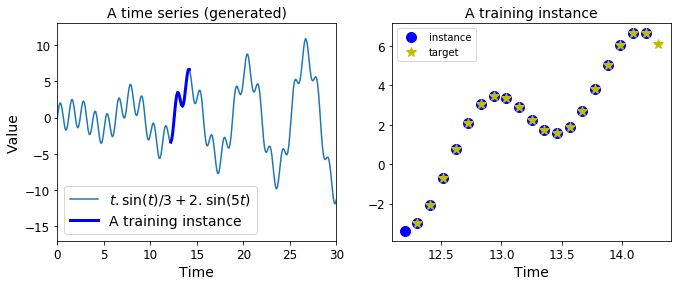

In [7]:
# everything github
# build time series
t_min, t_max = 0, 30                           # start and end
resolution = 0.1                               # resolution
def time_series(t):                            # x: time points
    return t * np.sin(t) / 3 + 2 * np.sin(t*5) # y: (harmonic with increasing amplitude) + (faster harmonic)
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))               # x-values
n_steps = 20                                                                   # 20 steps per instance
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1) # some specific instance
# make plots
plt.figure(figsize=(11,4))
# first plot
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")         # full time series
plt.plot(t_instance[:-1], time_series(t_instance[:-1]),                        # instance of 20-steps time series
         "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")
# second plot
plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo",                  # instance of 20-steps time series
         markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "y*"                     # use y* instead of w* to avoid white
         , markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.show()

Our RNN cell shall consist of 100 neurons and it will be unrolled over 20 time steps, at each of which only one feature will be fed as input.

**General note**<br>
In general you would have more than just one input feature. For example, if you were trying to predict stock prices, you would likely have many other input features at each time step, such as prices of competing stocks, ratings from analysts, or any other feature that might help the system make its predictions.

But due to the 100 neurons, the cells output dimension would be hundred instead of 1. This situation is easily remedied by wrapping an `OutputProjectionWrapper` around the cell. This adds a **fully connected, linear** (i.e., without activation function) layer on top of the default cell such that its **output has the desired dimension**. At the same time, it **keeps the default cell's state** / "output" so it can be added to the input for the next time step and **proxies all other methods** of the default cell. All these (unrolled) fully connected layers share the same weight and bias terms.

In [8]:
# github: function to get random batches
def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1) # time series, shifted time series
### construction
reset_graph()
# architecture
n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])
# RNN cell: put an "OutputProjectionWrapper" around the default cell to produce output of the desired dimension
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu), # default cell
    output_size=n_outputs)                                                   # specify desired dimension of output
# unroll the RNN cell to obtain the outputs and internal states for each time step; here, the states are never ...
# ... used, at least not explicitly: it is not clear whether "OutputProjectionWrapper" reuses the states ...
# ... automatically (but my suspicion is that it does: otherwise there would be no use in using the wrapper, here)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
# training details
n_iterations = 1501 # changed from default 1500
batch_size = 50
learning_rate = 0.001
# cost function and optimizing
loss = tf.reduce_mean(tf.square(outputs - y)) # supervised learning: the "outputs" list shall match the label list "y"
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
# initializer and saver nodes
init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    saver.save(sess, "./tf_logs/14_RNNs/1_TS-Wrapper/my_model")

0 	MSE: 14.468144
100 	MSE: 0.5394998
200 	MSE: 0.15449336
300 	MSE: 0.07192181
400 	MSE: 0.06320435
500 	MSE: 0.06210691
600 	MSE: 0.060552463
700 	MSE: 0.051254578
800 	MSE: 0.052466996
900 	MSE: 0.05002689
1000 	MSE: 0.05025828
1100 	MSE: 0.048713647
1200 	MSE: 0.04287989
1300 	MSE: 0.04902653
1400 	MSE: 0.043525316
1500 	MSE: 0.05338131


Training complete. Now, make a prediction and compare it to the true data. The result is shown in the plot below (similar to Figure 14-9 on page 396 of the book).

INFO:tensorflow:Restoring parameters from ./tf_logs/14_RNNs/1_TS-Wrapper/my_model


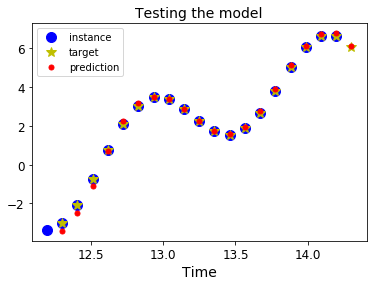

In [9]:
with tf.Session() as sess:
    saver.restore(sess, "./tf_logs/14_RNNs/1_TS-Wrapper/my_model")               # restore trained model
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps,n_inputs))) # "t_instance" defined for plot above
    y_pred = sess.run(outputs, feed_dict={X: X_new})                             # make a prediction
# use github code for plotting the training instance, the target, and the prediction
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "y*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.show()

This looks *very convincing*! But maybe that one was kind of easy to guess. Anyway, there is an alternative to the `OutputProjectionWrapper`: stacking one – and really only one for the entire unrolled RNN – fully connected layer on top of the cell output such that the desired dimension is reached (number of neurons in the fully connected layer). To do this, the outputs from (i) all time steps and (ii) all batch instances are stacked along the same dimension, thus yielding the shape `[batch_size * n_steps, n_outputs]`. This needs to be done manually because by default, they have separate dimensions. The original dimension of `n_outputs` remains unchanged. The origianl number of (batch) instances, multiplied by the number of time steps is now the total number of instances that can be used to train the dense layer. After a batch has gone through the layer, it is unstacked to the original shape of `[batch_size, n_steps, n_outputs]`.

0 	MSE: 13.714894
100 	MSE: 0.56018263
200 	MSE: 0.19036464
300 	MSE: 0.10639868
400 	MSE: 0.07191258
500 	MSE: 0.06396653
600 	MSE: 0.05671038
700 	MSE: 0.050866127
800 	MSE: 0.052114204
900 	MSE: 0.04824836
1000 	MSE: 0.048172064
1100 	MSE: 0.051140264
1200 	MSE: 0.041506734
1300 	MSE: 0.048908077
1400 	MSE: 0.044311717
1500 	MSE: 0.049740776


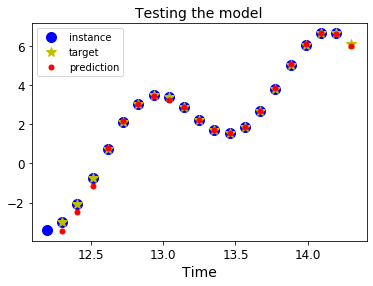

In [10]:
### construction
reset_graph()
# architecture
n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])
# RNN cell
cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons,activation=tf.nn.relu) # default cell
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)            # outputs, states (maybe the identical)
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])                # keep n_neurons dimension but stack ...
stacked_outputs  = tf.layers.dense(stacked_rnn_outputs, n_outputs)            # ... the rest, apply a dense layer ...
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])               # ... on n_neurons inputs, then unstack
# training details
n_iterations = 1501 # changed from default 1500
batch_size = 50
learning_rate = 0.001
# cost function and optimizing
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
# initializer and saver nodes
init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    saver.save(sess, "./tf_logs/14_RNNs/2_TS-Stack/my_model")
    # as above but using the original session (=> no need to restore it)
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
# still as above
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "y*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.show()

That also seems to work well: the output looks very similar to the previous model.
### Creative RNN
page 398<br>
With what has been done above, we can feed some initial time series to a model (below we use the second model above) and ask the model for the next value. Then, we use the latest `n_steps` steps of that time series as input for the following value. And so on and so forth. Doing this repeatedly, the model will **generate a creative time series**.

INFO:tensorflow:Restoring parameters from ./tf_logs/14_RNNs/2_TS-Stack/my_model
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
(20,)
(320,)


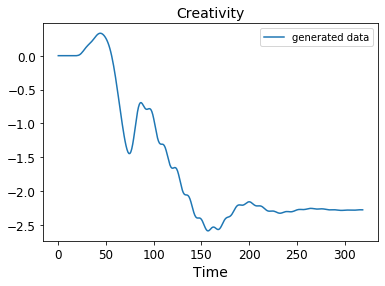

In [11]:
with tf.Session() as sess:
    saver.restore(sess, "./tf_logs/14_RNNs/2_TS-Stack/my_model")       # restore trained model
    sequence = [0] * n_steps                                           # 20 time steps, all with 0s
    print(sequence)
    print(np.array(sequence).shape)
    for iteration in range (300):                                      # loop over 300 iterations
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1) # always feed the last 20 time steps ...
        y_pred = sess.run(outputs, feed_dict={X: X_batch})             # ... to infer the next data point ...
        sequence.append(y_pred[0, -1, 0])                              # ... and append it to the sequence
print(np.array(sequence).shape)                                        # session finished, final shape
# plot the total time series
plt.title("Creativity", fontsize=14)
plt.plot(range(len(sequence)), sequence, "-", markersize=10, label="generated data")
plt.legend(loc="upper right")
plt.xlabel("Time")
plt.show()

Works well! We could feed the model input from *Aphex Twin* and ask it to generate similar art. However, a more powerful will be necessary. Let's make a more powerful RNN by making the network deep!
## Deep RNNs
page 398<br>
If we want to have an RNN cell with several layers then we can just define these layers via `BasicRNNCell`, for exmaple, put them in a list, and feed this list of RNN layers to `MultiRNNCell`. The following code shows an example fro how this can be done.

In [12]:
# github
reset_graph()
n_inputs = 2
n_steps = 5
batch_size = 13   # own code
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
# book (this is the relevant part, here)
n_neurons = 100   # number of neurons in each layer (could also be different for different layer)
n_layers = 3      # number of layers in multi_layer_cell
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons,activation=tf.nn.relu) # build layers and put ...
          for layer in range(n_layers)]                                          # ... them into "layers"
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers, state_is_tuple=False)     # MultiRNNCell
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
# github
init = tf.global_variables_initializer()
X_batch = np.random.rand(batch_size, n_steps, n_inputs)                          # batch_size is own code (default: 2)
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})
outputs_val.shape # (batch_size, n_steps, n_neurons)

(13, 5, 100)

The `states` variable is a tensor that contains the **state of the last hidden layer** for every instance and every time step. Consequently, it has shape $(\rm{batch size, n\_steps, n\_neurons})$, as demonstrated by the output above. The figure below (similar to Figure 14-12 on page 399 of the book) illustrates how the states of hidden layers are automatically fed to the according layers for the next time step.
<img src="images/state_feed.png">
### Distributing a Deep RNN Across Multiple GPUs
page 399<br>
Chapter 12 discusses that deep RNNs can be efficiently distributed across multiple GPUs. However, creating each cell (layer) in a different device as shown below does not work.

`with tf.device("/gpu:0"): # BAD! This is ignored.
    layer1 = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
with tf.device("/gpu:1"): # BAD! This is ignored again.
    layer2 = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)`

The reason is that `BasicRNNCell` is a cell factory and not a cell itself. Only when calling `dynamic_rnn()` (or `static_rnn()`), it calls `MultiRNNCell` which calls each individual `BasicRNNCell`, thus finally creating and actual cell and its according variables. As of the state of the book (June 9, 2017), none of these classes provide control over the distribution of variables across devices. The trick is to create a custom cell wrapper class as in the code below.

In [13]:
### book
# define own cell wrapper class
class DeviceCellWrapper(tf.contrib.rnn.RNNCell):
    def __init__(self, device, cell):    # receive device argument
        self._cell = cell
        self._device = device
    @property
    def state_size(self):
        return self._cell.state_size
    @property
    def output_size(self):
        return self._cell.output_size
    def __call__(self, inputs, state, scope=None):
        with tf.device(self._device):    # use device argument
            return self._cell(inputs, state, scope)
# use own cell wrapper class
devices = ["/cpu:0", "/cpu:0", "/cpu:0"] # adapt this to available hardware
cells = [DeviceCellWrapper(dev, tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)) for dev in devices] # relevant part!
multilayer_cell = tf.contrib.rnn.MultiRNNCell(cells)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
### github
init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()                           # initializer variables on devices; next is an own adaption
    print((sess.run(outputs, feed_dict={X: np.random.rand(batch_size, n_steps, n_inputs)})).shape)    # outputs shape

(13, 5, 100)


**Warning / caution**<br>
Do not set `state_is_tuple=False`, or the `MultiRNNCell` will concatenate all the cell states into a single tensor, on a single GPU.
### Applying Dropout
page 400<br>
The overall concept of dropout is the same for RNNs as for other networks. But as we deal with cell (layer) factories instead of cells (layers) per se, we need to wrap these cell factories into a `DropoutWrapper` before stacking them together.

0 	MSE: 14.741174
100 	MSE: 6.7942157
200 	MSE: 7.0776253
300 	MSE: 7.109744
400 	MSE: 6.3107615
500 	MSE: 5.3762517
600 	MSE: 5.1904216
700 	MSE: 6.214761
800 	MSE: 6.5270762
900 	MSE: 5.809282
1000 	MSE: 4.5022225
1100 	MSE: 7.210046
1200 	MSE: 5.4441333
1300 	MSE: 4.6030946
1400 	MSE: 4.014439
1500 	MSE: 4.625908


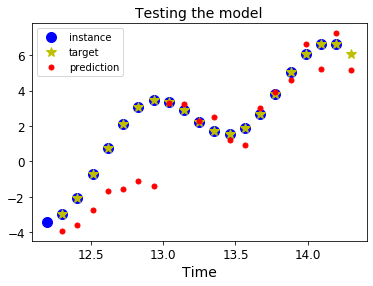

In [14]:
# architecture
reset_graph()
n_steps = 20
n_inputs = 1
n_neurons = 100
n_layers = 3                                                                                   # layers number added
n_outputs = 1
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])
# RNN cell
### new
keep_prob = 0.35                                                                               # adapted from 0.5
cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons) for layer in range(n_layers)]        # layers / cells list
cells_drop = [tf.contrib.rnn.DropoutWrapper(cell,input_keep_prob=keep_prob) for cell in cells] # wrap cells in dropout
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells_drop)                                     # make multilayer cell
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)                 # outputs, states
### continue as above
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs  = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
# training details
n_iterations = 1501 # changed from default 1500
batch_size = 50
learning_rate = 0.001
# cost function and optimizing
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
# initializer and saver nodes
init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    saver.save(sess, "./tf_logs/14_RNNs/3_TS-Dropout/my_model")
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
# make plot
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "y*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.show()

This looks rather disappointing. The reason is that with the above code, dropout is also applied during inference. Remember that it should only be applied during training (see Chapter 11)! This issue can be easily remedied by 
- using a placeholder for the keep rate instead of a specific number and
- feeding the appropriate keep rate for training (usually smaller than 1) and for inference (1).

This is a bit different from the code in the book but shown on GitHub (link above) and implemented below.

0 	MSE: 10.506571
100 	MSE: 13.575205
200 	MSE: 15.652719
300 	MSE: 13.45711
400 	MSE: 14.26611
500 	MSE: 14.863416
600 	MSE: 16.985506
700 	MSE: 17.705675
800 	MSE: 18.289787
900 	MSE: 20.3862
1000 	MSE: 18.99865
1100 	MSE: 21.76687
1200 	MSE: 18.622782
1300 	MSE: 19.812231
1400 	MSE: 19.52719
1500 	MSE: 21.961754


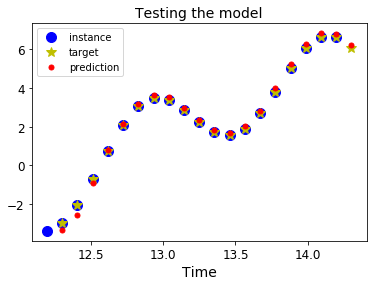

In [15]:
# architecture
reset_graph()
n_steps = 20
n_inputs = 1
n_neurons = 100
n_layers = 3                                                                                   # layers number added
n_outputs = 1
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])
# RNN cell
### new
keep_prob = tf.placeholder_with_default(1.0, shape=())                                         # see github
train_keep_prob = 0.475                                                                        # adapted from 0.5
cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons) for layer in range(n_layers)]        # layers / cells list
cells_drop = [tf.contrib.rnn.DropoutWrapper(cell,input_keep_prob=keep_prob) for cell in cells] # wrap cells in dropout
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells_drop)                                     # make multilayer cell
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)                 # outputs, states
### continue as above
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs  = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
# training details
n_iterations = 1501
batch_size = 50
learning_rate = 0.001
# cost function and optimizing
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
# initializer and saver nodes
init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch, keep_prob: train_keep_prob})    # feed train_keep_prob
            print(iteration, "\tMSE:", mse)
    saver.save(sess, "./tf_logs/14_RNNs/4_TS-Dropout-Train/my_model")
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
# make plot
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "y*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.show()

### The Difficulty of Training over Many Time Steps
page 402<br>
If the (multilayer) RNN uses different trainable variables for different time steps, as is not necessarily the case, then unrolling the network over many time steps can correspond to a very deep network. This can make training very slow, for the same reasons as for a normal network: vanishing / exploding gradients (see Chapter 11). The cures are also familiar:
- good initialization of the trainable variables,
- non-saturating activation functions,
- batch-normalization or gradient clipping, and
- performant optimizers.

However, even moderately long sequences (say, 100 steps) may cause training to be very slow. The simplest and most common way to tackle this is to truncate the sequence for training, i.e., to reduce `n_steps`. If short-, mid-, and long-range patterns are all expected to be relevant, one may take them all into account by training, e.g., on daily (monthly) [yearly] data of the last 10 days (months) [years]. However, this would not catch a short-term event of a long time ago that is still relevant, e.g., an election.<br>
Moreover, early events tend to fade away on the long run as the original information is transformed over and over again. Soon, hardly any trace of such event is left. This can be a showstopper for a sentiment analysis of movie reviews. Say, a review started with the words "The movie was awesome!", followed by a long list of remarks that could have made the movie better. If the RNN forgets about the positive early part and only retains the critique, the sentiment analysis will fail. Several RNN cell architectures aim to solve this problem. In the following, we introduce two of them: the LSTM cell and the GRU cell.
## LSTM Cell
page 402<br>
The **Long Short-Term Memory** (LSTM) cell was introduced by Sepp Hochreiter and Jürgen Schmidhuber in 1997 (https://goo.gl/j39AGv) and has been improved over the course of several years since (https://goo.gl/6BHh81, https://goo.gl/SZ9kzB). In its basic form (`BasicLSTMCell`), it can almost be used like a basic normal cell (`BasicRNNCell`) with the command `lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)` but it will usually perform much better. LSTM cells keep track of two state vectors:
- A short-term state $h_{(t)}$ and
- a long-term state $c_{(t)}$.

By default, these state vectors are kept separate but this may be changed via `state_is_tuple=False`. An LSTM cell contains 4 different fully connected layers:
- The main layer, $g_{(t)}$, is similar to a **basic cell** that receives input and returns an output that would usually be the final output $y_{(t)}$. But in an LSTM, this output is first filtered by the input gate and then added to the long-term state. The resulting long-term state $c_{(t)}$ is (i) fed forward to the next time step and (ii) sent through a $\text{tanh}$ activation before being controlled by an output gate. The result after the output gate is the final output $y_{(t)}$ and (at the same time) the new short-term state $h_{(t)}$ which will be fed as input along $x_{(t+1)}$ for the next time step.
- The three other fully connected layers are gate controllers. The logistic activation functions map the outputs to a number between 0 (gate closed) and 1 (gate open) so they can be used as weights for the input to the gates.
 - The **forget gate** $f_{(t)}$ controls which part of the long-term state can be ditched.
 - The **input gate** $g_{(t)}$ determines which part of the basic, intermediate output $g_{(t)}$ shall be added to the long term state.
 - Finally, the **output gate** $o_{(t)}$ decides which part of the long-term state (after it has passed through the ${\rm tanh}$ activation) shall be returned as output $y_{(t)}$ (and as short-term state $h_{(t)}$).

**So for an LSTM, part of the output is stored in the long-term state.** This allows LSTMs to take into account important inputs (input gate), dismiss information that is no longer needed (forget gate), and use the information that is currently relevant (output gate). A sketch of an LSTM is shown below (similar to Figure 14-13 on page 403 in the book).
<img src="images/LSTM_cell.png">

The quantities processed by an LSTM can be calculated via (see Equation 14-3 on page 405 of the book)

$$i_{(t)}=\sigma\left(W_{xi}^T\cdot x_{(t)}+W_{hi}^T\cdot h_{(t-1)}+b_i\right)\,,\\
f_{(t)}=\sigma\left(W_{xf}^T\cdot x_{(t)}+W_{hf}^T\cdot h_{(t-1)}+b_f\right)\,,\\
o_{(t)}=\sigma\left(W_{xo}^T\cdot x_{(t)}+W_{ho}^T\cdot h_{(t-1)}+b_o\right)\,,\\
g_{(t)}=\tanh\left(W_{xg}^T\cdot x_{(t)}+W_{hg}^T\cdot h_{(t-1)}+b_g\right)\,,\\
c_{(t)}=f_{(t)}\otimes c_{(t-1)}+i_{(t)}\otimes g_{(t)}\,,\\
y_{(t)}=o_{(t)}\otimes \tanh\left(c_{(t)}\right)\,,\\
h_{(t)}=y_{(t)}\,,$$
where
- $W_{xi}$, $W_{xf}$, $W_{xo}$, $W_{xg}$ are the weight matrices of each of the four layers for their connection to the input vector $x_{(t)}$,
- $W_{hi}$, $W_{hf}$, $W_{ho}$, and $W_{hg}$ are the weight matrices of each of the four layers for their connection to the previous short-term state $h_{(t-1)}$, and
- $b_i$, $b_f$, $b_o$, and $b_g$ are the bias terms for each of the four layers. Note that TensorFlow initializes $b_f$ to a vector full of 1s instead of 0s. This prevents forgetting everything at the beginning of training.

In [16]:
### almost completely github
reset_graph()
# architecture
n_steps = 28     # 28 steps with 28 ...
n_inputs = 28    # ... inputs each (MNIST)
n_layers = 3     # layers of LSTM cells ...
n_neurons = 150  # ... with 150 neurons each
n_outputs = 10   # additional output layer at very end
# training details
learning_rate = 0.001
n_epochs = 4     # adapted from default 10
batch_size = 100 # adapted from default 150
# RNN
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])                                     # features
y = tf.placeholder(tf.int32, [None])                                                          # labels
lstm_cells = [tf.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons) for layer in range(n_layers)] # list of LSTM cells
multi_cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cells)                                          # stack cells into one
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)                          # outputs and states
top_layer_h_state = states[-1][1]                                      # get state of top (-1) hidden layer, but ...
                                                                       # ... only the short term one, h (1)
logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax") # apply dense layer: highest activation wins
# cost function and training operation
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
# classification and accuracy
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
# initializer (no saver, here)
init = tf.global_variables_initializer()
# use (slightly adapted) code from MNIST sequence classifier above
with tf.Session() as sess:                                   # start session
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            if epoch==0 and iteration==0:
                states_val, top_layer_h_state_val = sess.run([states, top_layer_h_state], feed_dict={X: X_batch})
                print(np.array(states_val).shape)            # shape of state: [n_layers, ?, batch_size, n_neurons]
                print(np.array(top_layer_h_state_val).shape) # shape of top hidden layer: [batch_size, n_neurons]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})  # use acc_batch instead of acc_train
        acc_test  = accuracy.eval(feed_dict={X: X_test , y: y_test })
        print(epoch, "Train accuracy:", acc_batch, "\tTest accuary:", acc_test)

(3, 2, 100, 150)
(100, 150)
0 Train accuracy: 0.97 	Test accuary: 0.9617
1 Train accuracy: 0.94 	Test accuary: 0.971
2 Train accuracy: 0.99 	Test accuary: 0.9797
3 Train accuracy: 0.96 	Test accuary: 0.9843


In 2000, Felix Giers and Jürgen Schmidhuber came up with the idea of **Peephole Connections** (https://ieeexplore.ieee.org/document/861302). The LSTM outlined above allows the four dense layers to look only at the current input, $x_{(t)}$ and the previous short-term state, $h_{(t-1)}$. It may be useful to give them insight into a bit more history. Setting `use_peepholes=True` in an LSTM will also feed the long-term state $c_{(t-1)}$ to the *input gate* and to the *forget gate*. With that, the current long-term state $c_{(t)}$ is computed and fed to the current *output gate* (along with the default input $x_{(t)}$). In code, one would use something like this:<br>
`lstm_cell = tf.contrib.rnn.LSTMCell(num_units=n_neurons, use_peepholes=True)`.

There are many variants of the LSTM cell and one of them is the GRU cell. We shall look at it next.
## GRU Cell
page 406<br>
The **Gated Recurrent Unit** (GRU) cell was proposed by Kyunghyun Cho *et al*. in 2014 in a paper that also an encoder-decoder network (https://goo.gl/ZnAEOZ). The GRU cell is a simplified version of the LSTM cell and it seems to work just as well. The main differences to the LSTM cell are as follows:
- It uses of only **one state** instead of two states (short-term and long-term for LSTM).
- There is a dedicated **gate controller that filters** what part of the state is forwarded as **input to the main layer** / basic cell.
- A **single gate controller** that outputs values between 0 and 1 controls both the **forget gate** ($1-\text{gate value}$) and the **input gate** ($\text{gate value}$).
- There is **no output gate**.

The GRU cell's math goes as follows (Equation 14-4 on page 407 of the book):

$$z{(t)}=\sigma\left(W_{xz}^T\cdot x_{(t)}+W_{hz}^T\cdot h_{(t-1)}\right)\,,\\
r{(t)}=\sigma\left(W_{xr}^T\cdot x_{(t)}+W_{hr}^T\cdot h_{(t-1)}\right)\,,\\
g{(t)}=\tanh\left(W_{xg}^T\cdot x_{(t)}+W_{hg}^T\cdot\left(r_{(t)}\otimes h_{(t-1)}\right)\right)\,,\\
h{(t)}=(1-z_{(t)})\otimes h_{(t-1)}+z_{(t)}\otimes g_{(t)}\,.$$

The quantities become clear via the figure below (similar to Figure 14-14 on page 406 of the book).
<img src="images/GRU_cell.png">

TensorFlow makes GRU cells available via the command `gru_cell = tf.contrib.rnn.GRUCell(num_units=n_neurons)`. Both LSTM cells and GRU cells are behind recent successes with RNNs, particularly for applications in *natural language processing* (NLP).
## Natural Language Processing
page 407<br>
Typical NLP applications are machine translation, automatic summarization, parsing (analysing strings of symbols conforming to a formal grammar https://en.wikipedia.org/wiki/Parsing, https://en.wikipedia.org/wiki/Formal_grammar), and sentiment analysis, amongst others. Many of these are now based on RNNs. Here, we dip our feed into machine translation, for which TensorFlow's great Word2Vec (https://www.tensorflow.org/tutorials/representation/word2vec) and Seq2Seq (https://github.com/tensorflow/nmt/tree/tf-1.4) tutorials may be very helfpul.
### Word Embeddings
page 407<br>
Given a vocabulary of, say, 50000 words one could – in principle – represent this vocabulary via one-hot encoding: any given word would be represented by a 50000-component vector full of 0s and a single 1. But first, this would not be very efficient and second, this representation does not take into account similarity of words, which is very useful for language processing. If the model knows that "I drink milk" is a valid sentence, then it should assume that "I drink water" is also a valid sentence while "I drink shoes" is not, because "water" is much closer to "milk" than "shoes". Embedding the vocabulary in a low-dimensional **vector space** (e.g., 150 dimensions) with continuous entries (instead of 0 and 1 for one-hot) allows words that are close to [far from] each other in **similarity** to be also close to [far from] each other in **distance**.

In practice, the word embeddings are initialized randomly and optimized during training in such a way that the network becomes better at performing its task. Usually this leads to a representation where embeddings that are close in distance correspond to words that are also close in meaning (similarity). Amazingly, the results are sometimes **organized in a meaningful way** where, e.g., a certain dimension refers to the **gender** of a noun or the **tense** of a word.

Input that is fed to the network should be mapped to the vocabulary. For words that are not part of the default vocabulary, this can still be done via preprocessing steps that remove word endings or replace words by predefined tokens like "[UNK]" for unknown words, "[NUM]" for numerical values, or "[URL]" for weblinks. Then, it should be possible to look up each input's identifier number in the vocabulary via TensorFlow's `embedding_lookup()` function.

Once the embeddings have been learned (i.e., close words are similar), the obtained representation is actually useful for different NLP tasks. This makes sense because "milk" is still closer to "water" than "shoes", no matter the application! So it may makes sense to download pretrained embeddings. One can freeze them via `trainable=False` for faster training or retrain them for (hopefully) better performance on a specific task. Now to the implementation!

In [18]:
### almost everything github
# import all necessary libraries and take other initial steps so the notebook can be started from here
from six.moves import urllib
import errno
import os
import zipfile
from collections import Counter
from collections import deque
from sklearn.manifold import TSNE
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
# get the data
WORDS_PATH = "datasets/chapter14/words"                           # adapted save directory (default: "datasets/words")
WORDS_URL = "http://mattmahoney.net/dc/text8.zip"                 # source file
def fetch_words_data(words_url=WORDS_URL, words_path=WORDS_PATH): # download function
    os.makedirs(words_path, exist_ok=True)                        # make all necessary directories
    zip_path = os.path.join(words_path, "words.zip")              # the local file path ...
    print(zip_path)                                               # ... is printed
    if not os.path.exists(zip_path):                              # download the data if it does not exist, yet
        urllib.request.urlretrieve(words_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:                          # open the local file ...
        data = f.read(f.namelist()[0])                            # ... and read in the data
    return data.decode("ascii").split()                           # return the data in the specified format
words = fetch_words_data()                                        # use the above function to retrieve all the words
# show some data
print(words[:12])
# vocabulary
vocabulary_size = 50000                                           # size of vocabulary (is obviously limited)
vocabulary = [("UNK", None)] + Counter(words).most_common(vocabulary_size -1) # use the most common (sorted) words ...
print(vocabulary[:7])                                             # ... and a dummy entry for unknown words; print few
vocabulary = np.array([word for word, _ in vocabulary])           # now, we do no longer care about word frequency 
# dictionary
dictionary = {word: code for code, word in enumerate(vocabulary)} # assign numbers 0 to 49999 to the vocabulary words
dictionary

datasets/chapter14/words/words.zip
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working']
[('UNK', None), ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873)]


{'UNK': 0,
 'the': 1,
 'of': 2,
 'and': 3,
 'one': 4,
 'in': 5,
 'a': 6,
 'to': 7,
 'zero': 8,
 'nine': 9,
 'two': 10,
 'is': 11,
 'as': 12,
 'eight': 13,
 'for': 14,
 's': 15,
 'five': 16,
 'three': 17,
 'was': 18,
 'by': 19,
 'that': 20,
 'four': 21,
 'six': 22,
 'seven': 23,
 'with': 24,
 'on': 25,
 'are': 26,
 'it': 27,
 'from': 28,
 'or': 29,
 'his': 30,
 'an': 31,
 'be': 32,
 'this': 33,
 'which': 34,
 'at': 35,
 'he': 36,
 'also': 37,
 'not': 38,
 'have': 39,
 'were': 40,
 'has': 41,
 'but': 42,
 'other': 43,
 'their': 44,
 'its': 45,
 'first': 46,
 'they': 47,
 'some': 48,
 'had': 49,
 'all': 50,
 'more': 51,
 'most': 52,
 'can': 53,
 'been': 54,
 'such': 55,
 'many': 56,
 'who': 57,
 'new': 58,
 'used': 59,
 'there': 60,
 'after': 61,
 'when': 62,
 'into': 63,
 'american': 64,
 'time': 65,
 'these': 66,
 'only': 67,
 'see': 68,
 'may': 69,
 'than': 70,
 'world': 71,
 'i': 72,
 'b': 73,
 'would': 74,
 'd': 75,
 'no': 76,
 'however': 77,
 'between': 78,
 'about': 79,
 'over': 80

Above, we have imported the data (after downloading it in the first run). It is just a lot of text. Then we have counted the words, sorted them after frequency (how often a word appears) and then reduced the collection of words to 50000 by taking the 49999 most common words plus one dummy word for all other words. Finally, we have built a dictionary that translates words to numbers. Due to the sorting, the lower the number the more often a word appears. But this might not matter for the next steps.<br>
Below, we use the dictionary to assign each word in the original data (`words`) a number. Here, the `get()` method is crucial since it automatically returns the second argument ("0", i.e., "unknown") if the word does not appear in the dictionary (see also https://docs.quantifiedcode.com/python-anti-patterns/correctness/not_using_get_to_return_a_default_value_from_a_dictionary.html). Now, `data` is the translation of `words` according to `dictionary`. Indeed the lengths are the same.

In [19]:
data = np.array([dictionary.get(word, 0) for word in words]) # data=dictionary numbers for all words (could be "UNK")
print(data.shape)                                            # "words" is much richer than "dictionary"
n = 8                                                        # for the first n words from "words", print the word ...
print(" ".join(words[:n]), data[:n])                         # ... and the matching dictionary number
print(" ".join([vocabulary[word_index] for word_index in [5234, 3081, 12, 6, 195, 2, 3134, 46]])) # numbers to words
print(words[187], data[187])                                 # both
len(words), len(data)                                        # lengths of "words" and "data"

(17005207,)
anarchism originated as a term of abuse first [5234 3081   12    6  195    2 3134   46]
anarchism originated as a term of abuse first
offer 2034


(17005207, 17005207)

We will need a function that generates batches of labelled data to the algorithm. The size of a batch is `batch_size`. Each instance appears `num_skips` times in a batch. Appropriate labels (similar i.e. close instances) must lie within distance `skip_window` of the batch instance that shall be trained on. When running the training operation, the embeddings of the instances in the batch are updated. See also https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py.

In [20]:
def generate_batch(batch_size, num_skips, skip_window):       # function that generates batches
    global data_index                                         # this is the same "data_index" outside the ...
    # ... function, see also https://www.programiz.com/python-programming/global-local-nonlocal-variables
    assert batch_size % num_skips == 0                        # the entire batch shall be used (no rest)
    assert num_skips <= 2 * skip_window                       # num_skips may not be larger than 2*skip_window
    # "assert" is a debugging feature that checks if these statements are true and raises an error if not, see ...
    # ... also https://dbader.org/blog/python-assert-tutorial
    batch = np.ndarray(shape=[batch_size], dtype=np.int32)    # we declare these batch and labels containers but ...
    labels = np.ndarray(shape=[batch_size, 1],dtype=np.int32) # ... do not fill them, yet (details on np.ndarray ...
    # ... can be found on https://docs.scipy.org/doc/numpy/reference/arrays.ndarray.html)
    span = 2 * skip_window + 1                                # [skip_window, target, skip_window] 
    buffer = deque(maxlen=span)                               # discard all but the last span elements in buffer
    for _ in range(span):                                     # loop over span
        buffer.append(data[data_index])                       # include current data entry into buffer
        #print((data_index, buffer))                          # print this for better understanding
        data_index = (data_index + 1) % len(data)             # next: data_index +=1 (and start over at the end)
    for i in range(batch_size // num_skips): #??
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):                            # loop over num_skips
            while target in targets_to_avoid:                 # the target may not be in the list targets_to_avoid ...
                target = np.random.randint(0, span)           # ...  but shall be in span and chosen randomly
            targets_to_avoid.append(target)                   # do not repeat a target
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])                       # include current data entry into buffer
        data_index = (data_index + 1) % len(data)             # next: data_index +=1 (and start over at the end)
    return batch, labels
np.random.seed(42)                          # fixed seed for random numbers
data_index = 0                              # initialize data_index to 0
batch, labels = generate_batch(9, 3, 2)     # call the above function to obtain a batch of labeled instances
for i in range(len(batch)):                 # print a whole batch of features and labels side to side
    print([i, vocabulary[batch[i]], vocabulary[labels[i][0]]])
str(words[:12])                             # show a larger context for reference

[0, 'as', 'a']
[1, 'as', 'term']
[2, 'as', 'originated']
[3, 'a', 'of']
[4, 'a', 'term']
[5, 'a', 'as']
[6, 'term', 'of']
[7, 'term', 'a']
[8, 'term', 'abuse']


"['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working']"

Now, build a network, feed the batch instances and labels, and run the training operation over and over in order to get words that are close in text also close in the embedding space. Of importance – but beyond the scope of this notebook – is the Noise-Contrastive Estimation (NCE) training loss. Further understanding into the NCE training loss can be gained by reading
- https://www.tensorflow.org/api_docs/python/tf/nn/nce_loss,
- https://www.tensorflow.org/extras/candidate_sampling.pdf,
- https://datascience.stackexchange.com/questions/13216/intuitive-explanation-of-noise-contrastive-estimation-nce-loss, and
- https://stackoverflow.com/questions/41475180/understanding-tf-nn-nce-loss-in-tensorflow/44099690#44099690.

In the third link of the above list, user "user154812" argues that predicting the next word in a sequence (this is what is done in the code below), is – in principle – a massive classification task, with as many classes as words in the vocabulary. However, the softmax function is very inefficient when used on a large (huge) number of classes. A possible solution is to feed the algorithm two options: one with the correct word and the other with a random word (the latter will in the very most cases not be appropriate). This way, the problem becomes a binary classification task. By doing this over and over again, good embeddings will be learned for all words in the vocabulary. Somehow, NCE loss has to do with that.

Another note on similarity and embeddings: Similar words $A$ , $A'$, and so on will usually appear in similar context, i.e., close to certain (but not mutually similar) words $B$, $C$, and so on. Then, the embeddings of $A$, $A'$, and so on should be close to more or less the same neighbors (embeddings of $B$, $C$, and so on). Otherwise, $A$ and $A'$ would not be really similar (e.g., interchangeable in a sentence). As a consequence, the embeddings of $A$ and $A'$ will be close to each other. While $B$ and $C$ share neighborship with $A$ in embedding space, at least some of their neighbors will not be neighbors of $A$. Otherwise we would have $C=B`$. This is how embeddings may be understood.

In [21]:
### construction
reset_graph()
# training details
batch_size = 128      # batch size
embedding_size = 128  # dimension of the embedding vector
skip_window = 1       # how many words to consider left and right
num_skips = 2         # how many times to reuse an input to generate a label
# next, pick a random validation set to sample nearest neighbors and limit the validation samples to the words ...
# ... that have a low numeric ID, which by construction are also the most frequent
valid_size = 16       # random set of words to evaluate similarity on
valid_window = 100    # only pick dev samples in the head of the distribution
valid_examples = np.random.choice(valid_window, valid_size, replace=False)  # valid_size integers (no repetitions) ...
num_sampled = 64      # number of negative examples to sample               # ... in [0, valid_window-1]
learning_rate = 0.01  # learning rate
num_steps = 2001      # changed from default 10001
# initialize embeddings
init_embeds = tf.random_uniform([vocabulary_size,embedding_size], -1.0,1.0) # random numbers for initialization ...
embeddings = tf.Variable(init_embeds)                                       # ... of trainable embeddings
# feature data
train_inputs = tf.placeholder(tf.int32, shape=[None])                       # input feature placeholder
embed = tf.nn.embedding_lookup(embeddings, train_inputs)                    # input feature embeddings
# label data
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1]) # feed labels for training through this placeholder
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)    # use constant labels for validation
# NCE loss function and training operation
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size,embedding_size], stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))          # trainable weights (above) and biases (here)
loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed, num_sampled, vocabulary_size))
optimizer = tf.train.AdamOptimizer(learning_rate)              # adam optimizer
training_op = optimizer.minimize(loss)
# no accuracy: we compute the cosine similarity between minibatch examples and all embeddings as a quality measure
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keepdims=True))      # vector of mean embedding amplitudes
normalized_embeddings = embeddings / norm                                        # unit vector version
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)  # validation embeddings' unit vector
similarity = tf.matmul(valid_embeddings, normalized_embeddings,transpose_b=True) # scalar product between the two
# initializer (no saver)
init = tf.global_variables_initializer()
### execution
with tf.Session() as sess:
    init.run()
    average_loss = 0                                    # start with 0 loss
    for step in range(num_steps):                       # loop over num_steps (=iterations)
        print("\rIteration: {}".format(step), end="\t") # print current iteration
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips,skip_window) # generate inputs and labels
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}         # feed inputs and labels
        _, loss_val = sess.run([training_op, loss],
                               feed_dict=feed_dict)     # update embeddings and calculate loss
        average_loss += loss_val                        # update loss
        if step % 2000 == 0:                            # print average loss every 2000 steps
            if step > 0:
                average_loss /= 2000                    # average loss over 2000 steps
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0                            # restart with 0 loss
        if step % 2000 == 0:                            # changed from default 10000
            sim = similarity.eval()                     # evaluate similarity
            for i in range(valid_size):                 # loop over valid_size
                valid_word = vocabulary[valid_examples[i]]                             # get valid_example
                top_k = 8                                                              # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]                            # get top_k closest words
                log_str = "Nearest to %s:" % valid_word                                # build string of ...
                for k in range(top_k):                                                 # ... valid_word and ...
                    close_word = vocabulary[nearest[k]]                                # ... the top_k closest ...
                    log_str = "%s %s," % (log_str, close_word)                         # ... words so it can ...
                print(log_str)                                                         # ... all be printed
    final_embeddings = normalized_embeddings.eval()     # finally, normalize the embeddings
np.save("./datasets/chapter14/my_final_embeddings.npy", final_embeddings)              # save final embeddings with np

Iteration: 0	Average loss at step  0 :  286.22625732421875
Nearest to people: approve, we, staat, nuremberg, vj, gambling, quicklime, wilhelm,
Nearest to can: kgb, hackney, necker, islanders, visionaries, pax, glennon, lev,
Nearest to than: instruction, adjoint, hypnotist, gte, chloroplasts, gluck, likud, foosball,
Nearest to its: pcd, validated, airliners, judaic, ogden, ferrara, watershed, quarrels,
Nearest to their: materialize, hulled, tot, constrain, geographer, sih, devotion, penang,
Nearest to have: stereotyped, tukey, taboo, valentinians, equivocation, bihari, sprawl, lott,
Nearest to six: protect, crystallography, nrc, extensionality, opteron, tudes, gernsback, arrives,
Nearest to over: pouring, lauderdale, anxiolytics, bert, scottsdale, working, tompkins, lakers,
Nearest to two: flunitrazepam, raisin, ltspkr, kaos, obstacles, excavating, imaginations, engaging,
Nearest to UNK: accreditation, mutagenic, bassoon, salmon, incensed, disarming, inst, partisans,
Nearest to was: pho

Done. Now, let's plot some embeddings by reducing the dimension of the embeddings space from `embedding_size` down to `n_components=2` via TSNE (see Chapter 8)!

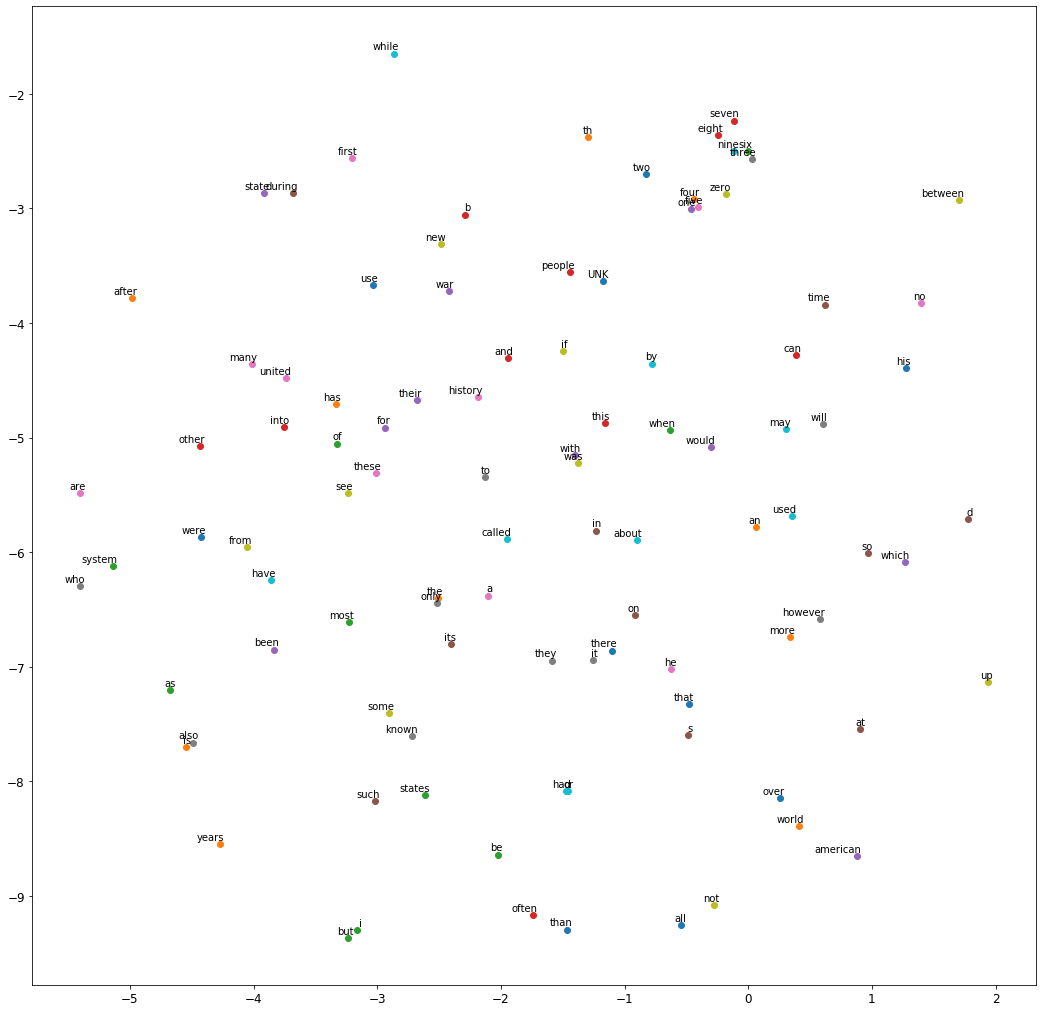

In [22]:
def plot_with_labels(low_dim_embs, labels):                                    # function to plot embeddings in 2D
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings" # there shall not be too many labels
    plt.figure(figsize=(18, 18))                                               # make figure
    for i, label in enumerate(labels):                                         # loop over labels
        x, y = low_dim_embs[i,:]                                               # get position of current label
        plt.scatter(x, y)                                                      # plot mark at position
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords="offset points", ha="right", va="bottom") # add label
tsne = TSNE(perplexity=30, n_components=2, init="pca", n_iter=5000)            # define TSNE reduction down to 2D
plot_only = 100                                                                # adapted from default 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])              # apply TSNE to selected embeddings
labels = [vocabulary[i] for i in range(plot_only)]                             # retrieve according labels
plot_with_labels(low_dim_embs, labels)                                         # feed arguments to function and plot

Despite the short training, there are already clusters of similar words appearing (e.g., numbers zero, one, two, etc. or words "this", "such", "the", "a", "some", "its"). This may differ from run to run but it shows that the algorithm works.

**Suggestion or Tip**<br>
Embeddings are also useful for representing categorical attributes that can take on a large number of different values, especially when there are complex similarities between values. For example, consider professions, hobbies, dishes, species, brands, and so on.

### An Encoder-Decoder Network for Machine Translation
page 409<br>
See also
- https://google.github.io/seq2seq/,
- https://github.com/google/seq2seq,
- https://www.tensorflow.org/beta/tutorials/text/nmt_with_attention, and
- https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/r2/tutorials/text/nmt_with_attention.ipynb (also, see / search for downloaded notebook *nmt_with_attention.ipynb*).

The image below (similar to Figure 14-15 on page 409 in the book) sketches an encoder-decoder network for translating English sentences to French sentences. The encoder is fed the embeddings of the English sentence. Only the final state of the last step is fed to the decoder. During training, the decoder is also fed the true input, i.e., what it should output at every step but the first. At the first step, the decoder is just fed a beginning-of-sequence token (namely $\text{<go>}$ in the figure below). The output of the decoder should be the target sentence but for the last output, which is an end-of-sequence token (namely $\text{<eos>}$ in the figure below). Also, the input to the encoder is reversed since usually, the decoder's first task is to translate the first word of the input. At each step, the decoder outputs scores for all words. These scores are transformed to probabilities via softmax. Usually, the word with the highest probability is chosen (depending on the application, randomness may also be involved). During application / inference, i.e., when training is over, one cannot feed the supervised input to the decoder. Instead, one simply feeds the $\text{<go>}$ token at the first step and for each other step simply the output of the previous step.

<img src="images/Seq2Seq.png">

The book also lists several remarks on some *rnn/translate/seq2seq_model.py* file that shall be existent in the TensorFlow models (https://github.com/tensorflow/models). But such file is currently not listed there. Moreover, the remarks can be looked up in the book so they are omitted, here.

## Exercises
page 412
### 1.-6.
Solutions are shown in Appendix A of the book and in the separate notebook *ExercisesWithoutCode*.
### 7. *Embedded Reber grammars* were used by Hochreiter and Schmidhuber in their paper about LSTMs. they are artificial grammars that produce strings such as "BPBTSXXVPSEPE". Ceck out Jenny Orr's nice indroduction (https://goo.gl/7CkNRn) to this topic. Choose a particular embedded Reber grammar (such as the one represented on Jenny Orr's page), then train an RNN to identify whether a string respects that grammar or not. You will first need to write a function capable of generating a training batch containing about 50% strings that respect the grammar, and 50% that don't.
We use the embedded Reber grammar shown below (and on Jenny Orr's web page). For context, a **Reber grammar** is a set of strings that has been obtained by a network of nodes similar to one of the two networks below (identical, with light gray, dashed circumference). This Reber grammar allows the creation of arbitrarily long strings but not of arbitrary strings. An **embedded Reber grammar** is what is shown by the network of (identical) networks below.
<img src="images/EmbeddedReberGrammar.png">

Let's build grammars and make strings with them!

In [23]:
### almost everything github
# import all necessary libraries and take other initial steps so the notebook can be started from here
import numpy as np
import tensorflow as tf
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
np.random.seed(42)
# Reber grammar
default_reber_grammar = [
    [("B", 1)],           # [(node 0) - (node 1): B]
    [("T", 2), ("P", 3)], # [(node 1) - (node 2): T] or [(node 1) - (node 3): P]
    [("S", 2), ("X", 4)], # [(node 2) - (node 2): S] or [(node 2) - (node 4): X]
    [("T", 3), ("V", 5)], # [(node 3) - (node 3): T] or [(node 3) - (node 5): V]
    [("X", 3), ("S", 6)], # [(node 4) - (node 3): X] or [(node 4) - (node 6): S]
    [("P", 4), ("V", 6)], # [(node 5) - (node 4): P] or [(node 5) - (node 6): V]
    [("E", None)]]        # [(node 6) - ("exit"): E]
# embedded Reber grammar
embedded_reber_grammar = [
    [("B", 1)],                   # [(node 0) - (node 1): B]
    [("T", 2), ("P", 3)],         # [(node 1) - (node 2): T] or [(node 1) - (node 3): P]
    [(default_reber_grammar, 4)], # [(node 2) - (node 4): default_reber_grammar]
    [(default_reber_grammar, 5)], # [(node 3) - (node 5): default_reber_grammar]
    [("T", 6)],                   # [(node 4) - (node 6): T]
    [("P", 6)],                   # [(node 5) - (node 6): P]
    [("E", None)]]                # [(node 6) - ("exit"): E]
# function that generates strings
def generate_string(grammar): # generate a string from "grammar"
    state = 0                 # start from node with state=0 ...
    output = []               # and with an empty string
    while state is not None:  # stop (the current level of) this function state is "None"
        index =np.random.randint(len(grammar[state])) # randomly choose (with equal probability) one of the ...
                                                      # ... (1 or 2) possible paths to the next state
        production, state = grammar[state][index]     # row (=state=current node, see above grammars!) and column  ...
        # ... (=next state) of current grammar => update state=node and obtain letter or another grammar
        if isinstance(production, list):                    # if production is a grammar (=list, see above), ...
            production =generate_string(grammar=production) # ... then jump to the next level of grammar, until a ...
        output.append(production)                           # ... non-list production is obtained; appent it to output
    return "".join(output)    # when state is "None", return the joined elements of output
# try out the string generation with the default Reber grammar ...
print("default Reber grammar:")
for _ in range(25):
    print(generate_string(default_reber_grammar), end=" ")
# ... and with the embedded Reber grammar
print("\n\nembedded Reber grammar:")
for _ in range(25):
    print(generate_string(embedded_reber_grammar), end=" ")

default Reber grammar:
BTXXTTVPXTVPXTTVPSE BPVPSE BTXSE BPVVE BPVVE BTSXSE BPTVPXTTTVVE BPVVE BTXSE BTXXVPSE BPTTTTTTTTVVE BTXSE BPVPSE BTXSE BPTVPSE BTXXTVPSE BPVVE BPVVE BPVVE BPTTVVE BPVVE BPVVE BTXXVVE BTXXVVE BTXXVPXVVE 

embedded Reber grammar:
BTBPVVETE BTBTSSSSSSSXXVVETE BPBTSSSXXTTTTVPSEPE BTBPTTVVETE BPBTXXTVVEPE BTBTXSETE BPBTSSSSSXXTTVPXVPXTTTVVEPE BPBTSSXXTVPSEPE BPBPTTTTTTTVPSEPE BTBTSXSETE BPBPTVPXVVEPE BPBPVVEPE BPBPTVVEPE BTBPTTVPXTTVPSETE BTBTSSXSETE BTBTXXTTVVETE BPBTSXSEPE BPBPTVPSEPE BTBPVVETE BPBTXXTTTVPXTVVEPE BPBPTTVPXTVVEPE BTBPVVETE BPBPTVPXVPXTVVEPE BTBPVVETE BPBTSXSEPE 

We want the RNN to discriminate between (Reber-) gramatically correct and incorrect strings. So incorrect strings would be very useful. The function below can create some.

In [24]:
def generate_corrupted_string(grammar,chars="BEPSTVX"): # use characters that do occur in the grammar (easy otherwise)
    good_string = generate_string(grammar)              # make a good string
    index = np.random.randint(len(good_string))         # choose a random position of that string
    good_char = good_string[index]                      # get the character at that position
    # elements in sets do not repeat (there is only one instance of an element or none) and they cannot be changed ...
    # ... once the set is defined, but the order of the elements can be canged, the difference leaves only those ...
    # ... elements that have not been subtracted (there is no "negative" element)
    bad_char = np.random.choice(sorted(set(chars) -set(good_char))) # choose a random character from the "set of ...
                                                                    # characters without good_char" (choose any other)
    return good_string[:index] + bad_char + good_string[index + 1:]
print("grammatically faulty strings:")
for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammar), end=" ")

grammatically faulty strings:
BTTTXXVVETE BPBTXXSPXTVVEPE BTBTXSPTE BPTTSXXTVPXVVEPE PPBPVPSEPE BTBPTVETE BPTTSSSSSXSEPE BPBSVPSEPE BTBPVVESE BPBTXSEPS BEBTXSETE XPBTXXTVPSEPE BTBPVVEPE BTXPTVVETE BTBPVXETE BVBTXSETE BPTTXXVPXVPSEPE BTBPXVPSETE STBPTTVPXVPXTVPSETE BPBPTVPSESE BPBPVEEPE ETBTXSETE BTBTXSVTE BPBTXXVPSEPP BTBTXXVPSETS 

The below function transforms a string, i.e., a sequence of letters to a sequence of one-hot vectors, where each one-hot vector corresponds to a letter. This is good for classification if each letter corresponds to a class.

In [25]:
def string_to_one_hot_vectors(string, n_steps, chars="BEPSTVX"):
    char_to_index = {char: index for index,char in enumerate(chars)} # dictionary that tranlates characters to indices
    output = np.zeros((n_steps, len(chars)), dtype=np.int32)         # 0-array of shape (n_steps, len(chars))
    for index, char in enumerate(string):                            # loop over string, get index and character
        output[index, char_to_index[char]] = 1.                      # replace 0 by 1 in row "index" and column ...
    return output                                                    # that corresponds to "char" => one-hot
string = "BTBTXSETE"                  # example string
print(string)                         # print it
string_to_one_hot_vectors(string, 12) # a row full of zeros means that there is no character (string already finished)

BTBTXSETE


array([[1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [26]:
def generate_dataset(size): # generate "size" strings 
    good_strings = [generate_string(embedded_reber_grammar) for _ in range(size // 2)]                 # half good
    bad_strings = [generate_corrupted_string(embedded_reber_grammar) for _ in range(size - size // 2)] # half bad
    all_strings = good_strings + bad_strings                                                           # both halfs
    n_steps = max([len(string) for string in all_strings])                               # length of longest string
    X = np.array([string_to_one_hot_vectors(string, n_steps)for string in all_strings]) # one-hot encoding all strings
    seq_length = np.array([len(string) for string in all_strings])                      # np.array of string lengths
    y = np.array([[1] for _ in range(len(good_strings))] +                              # 1 (0) for good (bad) ...
                 [[0] for _ in range(len(bad_strings))])                                # ... strings (still sorted)
    rnd_idx = np.random.permutation(size)                                               # random permutation of ...
    return X[rnd_idx], seq_length[rnd_idx], y[rnd_idx]                                  # ... all (still sorted) lists
X_train, l_train, y_train = generate_dataset(10000)                                     # 10000 training instances
print(X_train[0])
l_train[0], y_train[0]

[[1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


(23, array([0]))

Everything is set up so far. Now, let's build a network, train it, and see if it can distinguish (Reber)-gramatically correct sequences from incorrect ones!

In [27]:
### construction
# architecture
reset_graph()
possible_chars = "BEPSTVX"
n_inputs = len(possible_chars)
n_neurons = 30
n_outputs = 1
# training details
learning_rate = 0.02                         # no learning schedule
momentum = 0.95                              # Nesterov accelerated gradient optimizer hyperparameter
n_epochs = 21                                # adapted from default 50
batch_size = 20                              # adapted from default 50
X_val, l_val, y_val = generate_dataset(5000) # validation set
# RNN: inputs
X = tf.placeholder(tf.float32, [None, None, n_inputs],name="X") # feed one-hot instances (sequences of letter vectors)
seq_length = tf.placeholder(tf.int32, [None],name="seq_length") # feed lengths of sequences
y = tf.placeholder(tf.float32, [None, 1], name="y")             # feed label: 1 (0) true (false)
# RNN: GRU cell and dynamic unrolling
gru_cell = tf.nn.rnn_cell.GRUCell(num_units=n_neurons)                                         # n_neurons GRU cells
outputs, states = tf.nn.dynamic_rnn(gru_cell, X, dtype=tf.float32, sequence_length=seq_length) # outputs and states
print(states.shape)
# RNN: logits and outputs
logits = tf.layers.dense(states, n_outputs, name="logits")      # input: (batch_size, n_neurons=num_units=n_GRU_cells)
                                                                # output: neurons in dense layer = n_outputs = 1
y_pred = tf.cast(tf.greater(logits, 0.), tf.float32, name="y_pred")                            # predictions
y_proba = tf.nn.sigmoid(logits, name="y_proba")                                                # probability score
# cost function and training step
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)
# performance metric
correct = tf.equal(y_pred, y, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
# initializer and saver
init = tf.global_variables_initializer()
saver = tf.train.Saver()
### execution
with tf.Session() as sess:
    init.run()                    # initialize trainable variables
    for epoch in range(n_epochs): # loop over epochs
        X_batches = np.array_split(X_train, len(X_train) // batch_size)
        l_batches = np.array_split(l_train, len(l_train) // batch_size)
        y_batches = np.array_split(y_train, len(y_train) // batch_size)
        # next, loop over batches (for "zip", see https://www.w3schools.com/python/ref_func_zip.asp) and in each ...
        # ... step, run the training step and calculate the loss on the validation set
        for X_batch, l_batch, y_batch in zip(X_batches, l_batches, y_batches):
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, seq_length: l_batch, y: y_batch})
        # calculate and print accuracies
        acc_train = accuracy.eval(feed_dict={X: X_batch, seq_length: l_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_val, seq_length: l_val, y: y_val})
        print("{:3d}  Train loss: {:.5f}\t accuracy: {:.1f}%\t  Validation accuracy: {:.3f}%".format(
            epoch, loss_val, 100 * acc_train, 100 * acc_val))
    # save when done
    saver.save(sess, "./tf_logs/14_RNNs/5_ReberGrammar/RG_classifier")
# the second to last letter must be identical with the second letter, so ...
test_strings = ["BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE", # ... this one is not correct ...
                "BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE"] # ... but this one is correct
l_test = np.array([len(s) for s in test_strings])
max_length = l_test.max()
X_test = [string_to_one_hot_vectors(s, n_steps=max_length) for s in test_strings]
with tf.Session() as sess:
    saver.restore(sess, "./tf_logs/14_RNNs/5_ReberGrammar/RG_classifier")
    y_proba_val = y_proba.eval(feed_dict={X: X_test, seq_length: l_test})
print("\nEstimated probabilities that these are Reber strings:\n[solution: second (first) string is (not) correct]")
for index, string in enumerate(test_strings):
    print("{}: {:.2f}%".format(string, 100 * y_proba_val[index][0]))

(?, 30)
  0  Train loss: 0.66912	 accuracy: 70.0%	  Validation accuracy: 63.000%
  1  Train loss: 0.55111	 accuracy: 75.0%	  Validation accuracy: 73.720%
  2  Train loss: 0.37400	 accuracy: 95.0%	  Validation accuracy: 88.600%
  3  Train loss: 0.09150	 accuracy: 100.0%	  Validation accuracy: 97.360%
  4  Train loss: 0.00644	 accuracy: 100.0%	  Validation accuracy: 98.040%
  5  Train loss: 0.19163	 accuracy: 95.0%	  Validation accuracy: 96.840%
  6  Train loss: 0.00545	 accuracy: 100.0%	  Validation accuracy: 97.780%
  7  Train loss: 0.01282	 accuracy: 100.0%	  Validation accuracy: 98.080%
  8  Train loss: 0.00526	 accuracy: 100.0%	  Validation accuracy: 98.080%
  9  Train loss: 0.00434	 accuracy: 100.0%	  Validation accuracy: 98.140%
 10  Train loss: 0.00499	 accuracy: 100.0%	  Validation accuracy: 98.180%
 11  Train loss: 0.01270	 accuracy: 100.0%	  Validation accuracy: 97.000%
 12  Train loss: 0.00315	 accuracy: 100.0%	  Validation accuracy: 99.280%
 13  Train loss: 0.00137	 accuracy

The RNN understands the embedded Reber grammar. Simply AMAZING!
### 8. Tackle the "How much did it rain? II" Kaggle competition (https://goo.gl/0DS5Xe). This is a time series prediction task: you are given snapshots of polarimetric radar values and asked to predict the hourly rain gauge total. Luis Andre Dutra e Silva's interview (https://goo.gl/fTA90W) gives some interesting insights into the techniques he used to reach second place in the competition. In particular, he used an RNN composed of two LSTM layers.

In [28]:
print("A solution may follow later.")

A solution may follow later.


### 9. Go through TensorFlow's Word2Vec (https://www.tensorflow.org/tutorials/representation/word2vec) tutorial to create word embeddings, and then go through the Seq2Seq (https://google.github.io/seq2seq) tutorial to train an English-to-French translation system.

Word2Vec has been part of the above Section *Word Embeddings* further above (inspired by the code on GitHub). The Seq2Seq task is solved with the separate notebook *NMT_Seq2Seq.ipynb* (using Keras with a TensorFlow backend). The downloaded notebook *nmt_with_attention.ipynb* might also be useful in this context.